In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import glob

from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import seaborn as sns

2025-11-08 16:16:15.340243: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-08 16:16:15.379845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-08 16:16:16.304352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [9]:
import glob
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

# Путь к папке с изображениями - ПРОВЕРЬТЕ ЭТОТ ПУТЬ!
path = "Mask_data/images/"

# Сначала проверим, существуют ли файлы
print("Проверка пути...")
print(f"Путь существует: {os.path.exists(path)}")

# Посмотрим какие файлы там есть
png_files = glob.glob(path + "*.png")
print(f"Найдено PNG файлов: {len(png_files)}")
if png_files:
    print("Примеры файлов:", png_files[:3])

Проверка пути...
Путь существует: True
Найдено PNG файлов: 853
Примеры файлов: ['Mask_data/images/maksssksksss513.png', 'Mask_data/images/maksssksksss779.png', 'Mask_data/images/maksssksksss410.png']


In [12]:
 # Монтируем Google Диск
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # Распаковываем архив
# !unzip -q "/content/drive/MyDrive/Mask_data.zip" -d "/content/mask_dataset"

# Путь к папке с изображениями
path = "Mask_data/images/"

# Создаём словарь для данных
dataset = {
    "image_path": [],
    "mask_status": [],
    "which": []
}

# Проходим по всем PNG-файлам в папке images
for image_path in glob.glob(path + "*.png"):
    image_name = os.path.basename(image_path)  # Имя файла, напр. maksssksksss0.png

    # Извлекаем номер из имени (всё после 'maksssksksss' и до '.png')
    try:
        img_id = int(image_name.replace('maksssksksss', '').replace('.png', ''))
    except:
        continue  # Пропускаем, если не подходит под шаблон

    # Загружаем соответствующий XML-файл с аннотациями
    xml_path = f"Mask_data/annotations/maksssksksss{img_id}.xml"
    if not os.path.exists(xml_path):
        continue

    # Читаем XML (простой парсинг: ищем тег <name>)
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Определяем статус маски: если есть хотя бы один 'with_mask' — WithMask
    has_with_mask = any(obj.find('name').text == 'with_mask' for obj in root.findall('object'))
    status = "WithMask" if has_with_mask else "WithoutMask"

    # Определяем тип набора (пример: случайное разделение)
    # Или можно использовать фиксированное: первые 80% — Train, остальные — Test
    import numpy as np
    which = "Train" if np.random.rand() < 0.8 else "Test"

    # Добавляем данные
    dataset["image_path"].append(image_path)
    dataset["mask_status"].append(status)
    dataset["which"].append(which)

# Преобразуем в DataFrame
dataset = pd.DataFrame(dataset)

# Выводим результат
print(dataset.head(10))
print(f"Всего изображений: {len(dataset)}")
print(f"Статусы: {dataset['mask_status'].value_counts().to_dict()}")
print(f"Наборы: {dataset['which'].value_counts().to_dict()}")

                             image_path mask_status  which
0  Mask_data/images/maksssksksss513.png    WithMask  Train
1  Mask_data/images/maksssksksss779.png    WithMask  Train
2  Mask_data/images/maksssksksss410.png    WithMask  Train
3  Mask_data/images/maksssksksss491.png    WithMask  Train
4  Mask_data/images/maksssksksss472.png    WithMask  Train
5  Mask_data/images/maksssksksss552.png    WithMask  Train
6  Mask_data/images/maksssksksss743.png    WithMask  Train
7  Mask_data/images/maksssksksss582.png    WithMask  Train
8  Mask_data/images/maksssksksss197.png    WithMask  Train
9  Mask_data/images/maksssksksss200.png    WithMask  Train
Всего изображений: 853
Статусы: {'WithMask': 768, 'WithoutMask': 85}
Наборы: {'Train': 667, 'Test': 186}


С маской: 768
Без маски: 85


/tmp/ipykernel_1467/1917986052.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset["mask_status"], palette="viridis")


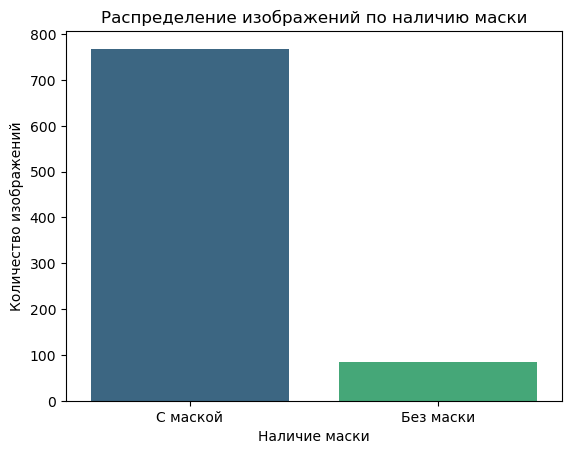

In [13]:
# Подсчитываем количество изображений с маской и без
print(f"С маской:", dataset.value_counts("mask_status")["WithMask"])
print(f"Без маски:", dataset.value_counts("mask_status")["WithoutMask"])

# Строим столбчатую диаграмму
sns.countplot(x=dataset["mask_status"], palette="viridis")

# Настраиваем подписи на русском
plt.title("Распределение изображений по наличию маски")
plt.xlabel("Наличие маски")
plt.ylabel("Количество изображений")

# Заменяем метки на оси X
plt.xticks(ticks=[0, 1], labels=["С маской", "Без маски"])

# Отображаем график
plt.show()

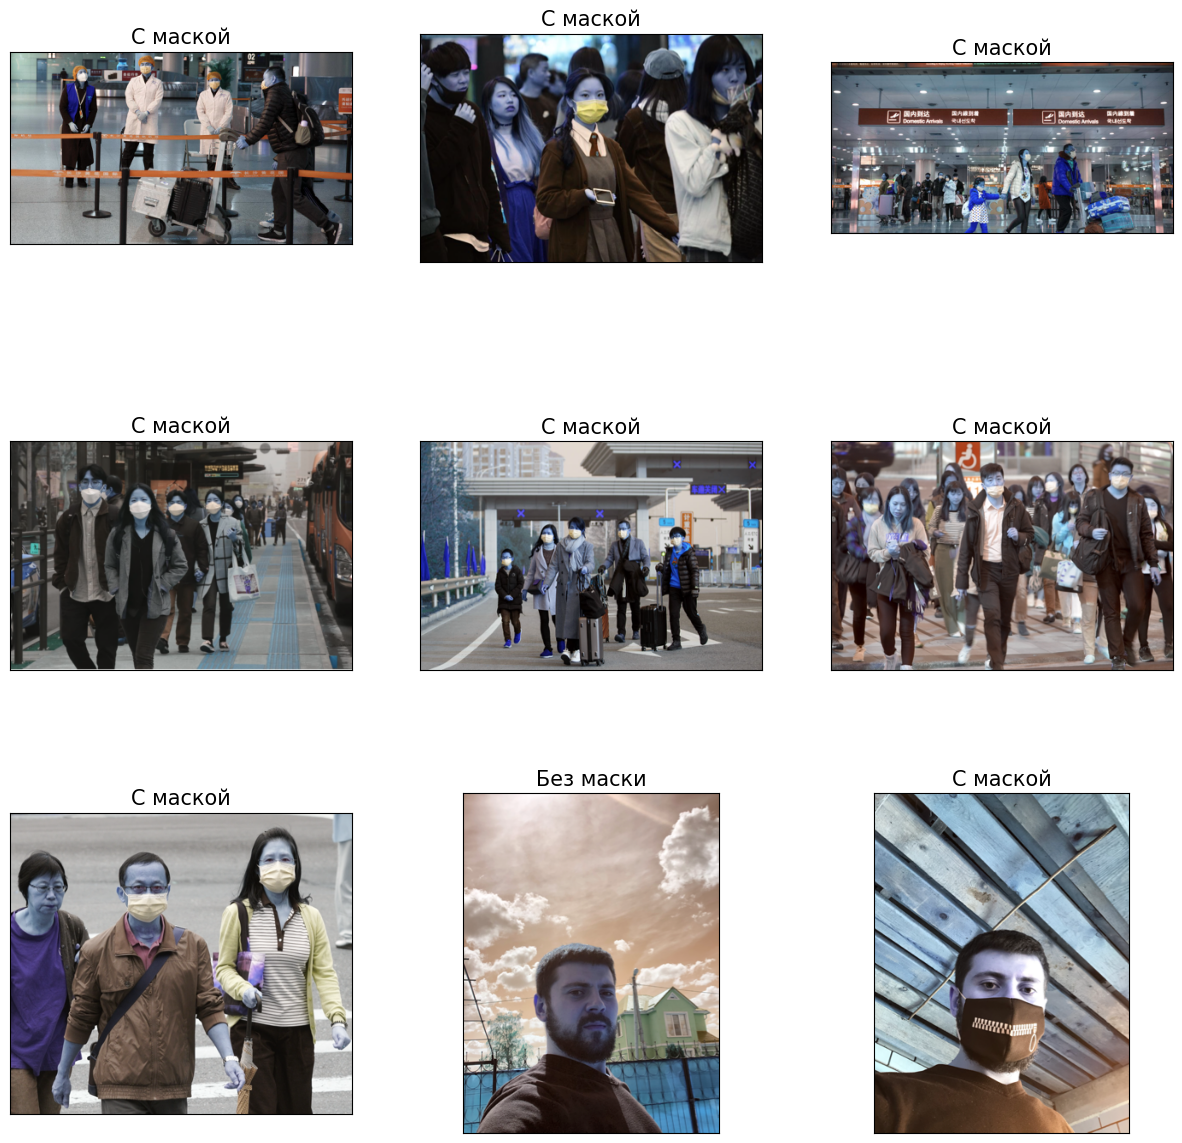

In [40]:
# Создаём фигуру размером 15x15 дюймов
plt.figure(figsize=(15, 15))

# Выводим 9 случайных изображений в сетке 3x3
for i in range(9):
    # Выбираем случайный индекс из датасета
    random = np.random.randint(0, len(dataset))

    # Рисуем подграфик в позиции i+1
    plt.subplot(3, 3, i + 1)

    # Загружаем и отображаем изображение по пути
    plt.imshow(cv2.imread(dataset.loc[random, "image_path"]))

    # Подписываем статус маски (на русском)
    status_ru = "С маской" if dataset.loc[random, "mask_status"] == "WithMask" else "Без маски"
    plt.title(status_ru, size=15)

    # Убираем оси
    plt.xticks([])
    plt.yticks([])

# Отображаем всю сетку
plt.show()

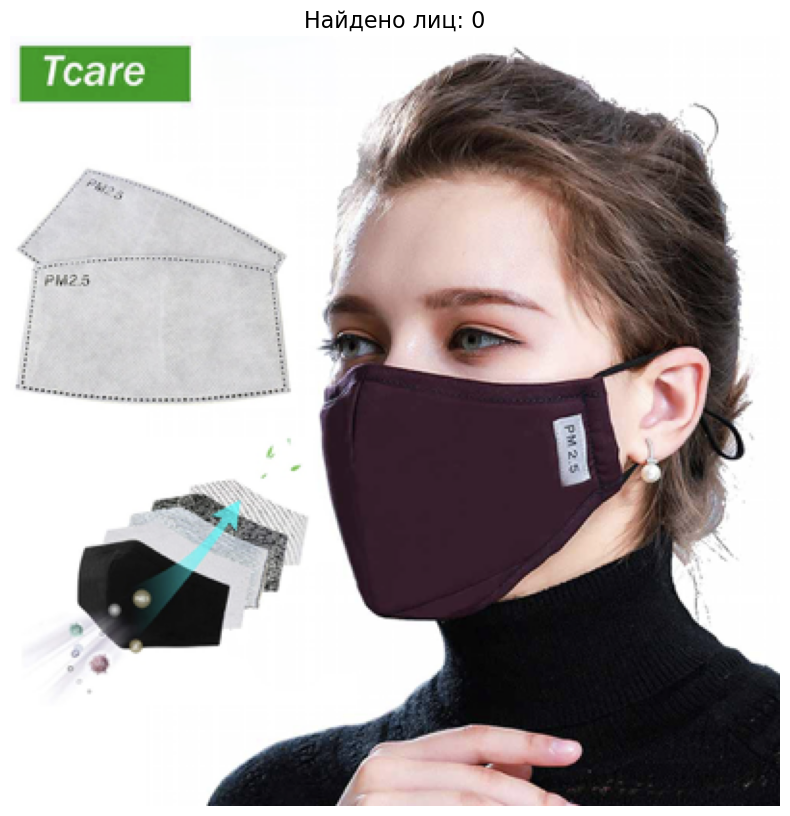

In [42]:
# Загружаем предобученный Haar Cascade для детекции лиц
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Берем путь к изображению из датасета (например, первое)
image_path = dataset.loc[7, "image_path"]

# Читаем изображение
img = cv2.imread(image_path)

# Проверяем, загрузилось ли изображение
if img is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path}")

# Преобразуем в оттенки серого
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Обнаруживаем лица
detected_faces = face_model.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Копируем оригинал для отрисовки
output_img = img.copy()

# Рисуем рамки вокруг лиц
for (x, y, w, h) in detected_faces:
    cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 3)

# Конвертируем BGR → RGB для корректного отображения в matplotlib
output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

# Показываем результат
plt.figure(figsize=(12, 10))
plt.imshow(output_img_rgb)
plt.title(f"Найдено лиц: {len(detected_faces)}", fontsize=16)
plt.axis('off')
plt.show()

In [23]:
# Разделяем датасет на тренировочную, тестовую и валидационную выборки
train_df = dataset[dataset["which"] == "Train"]      # Обучающая выборка
test_df  = dataset[dataset["which"] == "Test"]       # Тестовая выборка
valid_df = dataset[dataset["which"] == "Validation"] # Валидационная выборка (если есть)

# Выводим первые строки тренировочной выборки для проверки
print(train_df.head())

                             image_path mask_status  which
0  Mask_data/images/maksssksksss513.png    WithMask  Train
1  Mask_data/images/maksssksksss779.png    WithMask  Train
2  Mask_data/images/maksssksksss410.png    WithMask  Train
3  Mask_data/images/maksssksksss491.png    WithMask  Train
4  Mask_data/images/maksssksksss472.png    WithMask  Train


In [24]:
# Перемешиваем строки в каждой выборке для случайного порядка
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Тренировочная
test_df  = test_df.sample(frac=1, random_state=42).reset_index(drop=True)   # Тестовая
valid_df = valid_df.sample(frac=1, random_state=42).reset_index(drop=True) # Валидационная

# Сбрасываем индексы после перемешивания (новая нумерация с 0)
# drop=True — удаляем старый индекс

# Выводим первые строки перемешанной тренировочной выборки
print(train_df.head())

                             image_path mask_status  which
0  Mask_data/images/maksssksksss266.png    WithMask  Train
1  Mask_data/images/maksssksksss262.png    WithMask  Train
2   Mask_data/images/maksssksksss82.png    WithMask  Train
3  Mask_data/images/maksssksksss222.png    WithMask  Train
4  Mask_data/images/maksssksksss385.png    WithMask  Train


mask_status  WithMask  WithoutMask
which                             
Test              168           18
Train             600           67


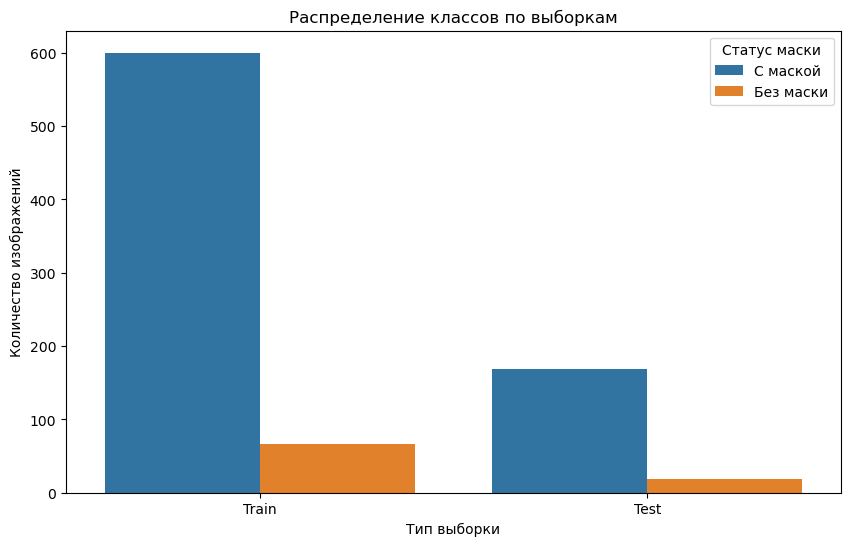

In [25]:
# Подсчитываем количество изображений по типам выборки и статусу маски
counts = dataset.groupby(["which", "mask_status"]).size().unstack(fill_value=0)
print(counts)

# Создаём график: распределение классов в Train/Test/Validation
plt.figure(figsize=(10, 6))
sns.countplot(x="which", hue="mask_status", data=dataset)

# Подписи на русском
plt.title("Распределение классов по выборкам")
plt.xlabel("Тип выборки")
plt.ylabel("Количество изображений")

# Легенда: WithMask → С маской, WithoutMask → Без маски
plt.legend(title="Статус маски", labels=["С маской", "Без маски"])

# Отображаем
plt.show()

In [26]:
# Размер изображения для входа в модель
IMG_SIZE = 150

# Словарь: метка класса (0 — с маской, 1 — без маски)
label_map = {"WithMask": 0, "WithoutMask": 1}

# Функция предобработки: загружает, ресайзит, нормализует изображения и метки
def preprocess_images(df):
    X = []  # Список изображений
    y = []  # Список меток
    for idx, row in df.iterrows():
        img = cv2.imread(row["image_path"])                    # Читаем изображение
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)             # BGR → RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))            # Приводим к 150x150
        img = img / 255.0                                      # Нормализация [0, 1]
        X.append(img)
        y.append(label_map[row["mask_status"]])                # Преобразуем статус в 0/1
    X = np.array(X, dtype="float32")                           # Массив изображений
    y = np.array(y)                                            # Массив меток
    return X, y

# Предобработка всех выборок
X_train, y_train = preprocess_images(train_df)  # Обучающая
X_valid, y_valid = preprocess_images(valid_df)  # Валидационная
X_test,  y_test  = preprocess_images(test_df)   # Тестовая

# One-hot кодирование меток (для categorical_crossentropy)
y_train_cat = to_categorical(y_train, num_classes=2)
y_valid_cat = to_categorical(y_valid, num_classes=2)
y_test_cat  = to_categorical(y_test,  num_classes=2)

In [29]:
# Создаём последовательную CNN для классификации масок
model = tf.keras.models.Sequential([
    # Слой 1: 100 фильтров 3×3, ReLU, вход: 150×150×3
    tf.keras.layers.Conv2D(100, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),  # Уменьшение размера в 2 раза

    # Слой 2: ещё 100 фильтров 3×3, ReLU
    tf.keras.layers.Conv2D(100, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),  # Ещё уменьшение

    tf.keras.layers.Flatten(),           # Преобразование 3D → 1D
    tf.keras.layers.Dropout(0.5),        # Отключение 50% нейронов (против переобучения)
    tf.keras.layers.Dense(50, activation='relu'),   # Полносвязный слой
    tf.keras.layers.Dense(2, activation='softmax')  # Выход: 2 класса (с/без маски)
])

# Компиляция модели
model.compile(
    optimizer='adam',                    # Адаптивный оптимизатор
    loss='categorical_crossentropy',     # Функция потерь для one-hot меток
    metrics=['accuracy']                 # Отслеживаем точность
)

# Выводим архитектуру модели
# model.summary()

In [33]:
# ПРАВИЛЬНО: X_train — numpy массив (N, 150, 150, 3)
X_train, y_train = preprocess_images(train_df)
X_test,  y_test  = preprocess_images(test_df)

# Если valid_df пуст — создаём валидацию из train
if len(valid_df) == 0:
    from sklearn.model_selection import train_test_split
    X_train, X_valid, y_train_cat, y_valid_cat = train_test_split(
        X_train, to_categorical(y_train, 2), test_size=0.2, random_state=42, stratify=y_train
    )
else:
    X_valid, y_valid = preprocess_images(valid_df)
    y_valid_cat = to_categorical(y_valid, 2)

# Теперь обучаем
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_valid, y_valid_cat),
    epochs=3,
    batch_size=32
)

Epoch 1/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 433ms/step - accuracy: 0.8668 - loss: 0.8260 - val_accuracy: 0.9030 - val_loss: 0.2990
Epoch 2/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 401ms/step - accuracy: 0.8987 - loss: 0.2944 - val_accuracy: 0.9030 - val_loss: 0.3392
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.8987 - loss: 0.2540 - val_accuracy: 0.9030 - val_loss: 0.2858


In [34]:
# Проверяем размеры данных перед обучением
print("X_train shape:", X_train.shape)  # Должно быть (N, 150, 150, 3)
print("y_train_cat shape:", y_train_cat.shape)  # (N, 2)
print("X_valid shape:", X_valid.shape)
print("y_valid_cat shape:", y_valid_cat.shape)

# Если X_valid пустой (valid_df пуст), убираем валидацию
if X_valid.size == 0:
    print("Валидационная выборка пуста — обучаем без validation_data")
    history = model.fit(
        X_train, y_train_cat,
        epochs=10,
        batch_size=32
    )
else:
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_valid, y_valid_cat),
        epochs=3,
        batch_size=32
    )

X_train shape: (533, 150, 150, 3)
y_train_cat shape: (533, 2)
X_valid shape: (134, 150, 150, 3)
y_valid_cat shape: (134, 2)
Epoch 1/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 0.8987 - loss: 0.2360 - val_accuracy: 0.9030 - val_loss: 0.3654
Epoch 2/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.9024 - loss: 0.2444 - val_accuracy: 0.9030 - val_loss: 0.2941
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.9343 - loss: 0.1498 - val_accuracy: 0.9030 - val_loss: 0.3332


In [35]:
assert X_train.shape[1:] == (150, 150, 3), "Неверный формат изображений!"
assert len(X_train) == len(y_train_cat), "Несоответствие X и y!"

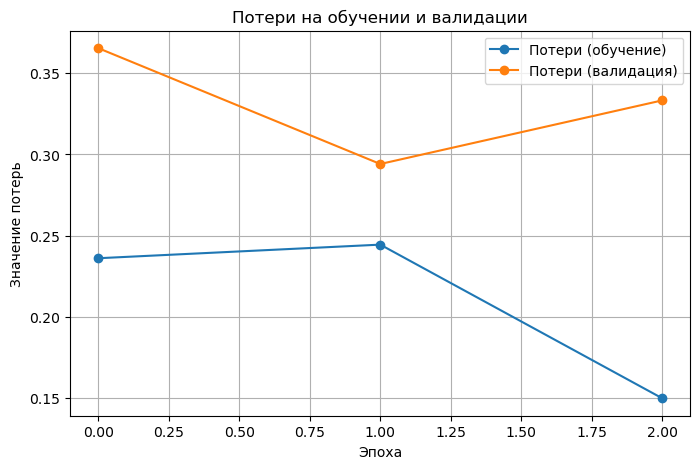

In [36]:
# Смотрим как ф-я потерь меняется по эпохам
# Создаём график размера 8×5
plt.figure(figsize=(8, 5))

# График потерь на обучении
plt.plot(history.history['loss'], label='Потери (обучение)', marker='o')

# График потерь на валидации
plt.plot(history.history['val_loss'], label='Потери (валидация)', marker='o')

# Название и подписи
plt.title('Потери на обучении и валидации')
plt.xlabel('Эпоха')
plt.ylabel('Значение потерь')

# Легенда и сетка
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()

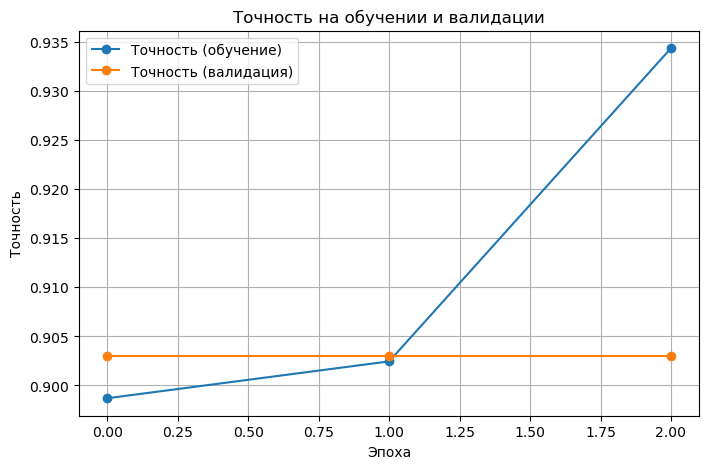

In [37]:
# Создаём график размера 8×5
plt.figure(figsize=(8, 5))

# График точности на обучении
plt.plot(history.history['accuracy'], label='Точность (обучение)', marker='o')

# График точности на валидации
plt.plot(history.history['val_accuracy'], label='Точность (валидация)', marker='o')

# Название и подписи
plt.title('Точность на обучении и валидации')
plt.xlabel('Эпоха')
plt.ylabel('Точность')

# Легенда и сетка
plt.legend()
plt.grid(True)

# Отображаем график
plt.show()

In [38]:
# Оцениваем модель на тестовой выборке
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)

# Выводим точность на тесте в процентах
print(f"Точность на тесте: {test_acc*100:.2f}%")

Точность на тесте: 90.32%


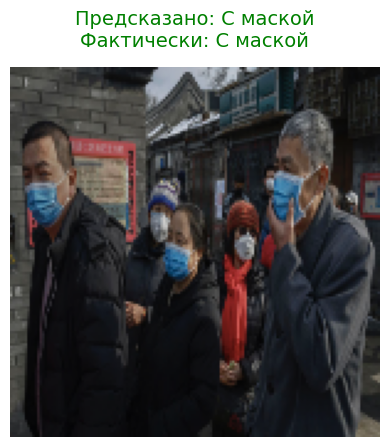

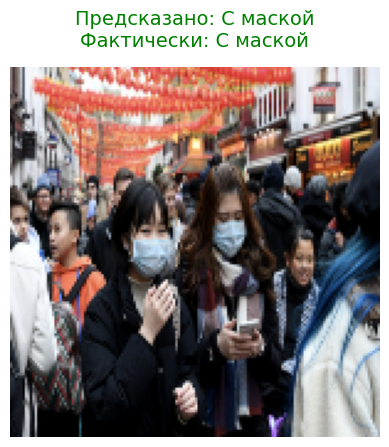

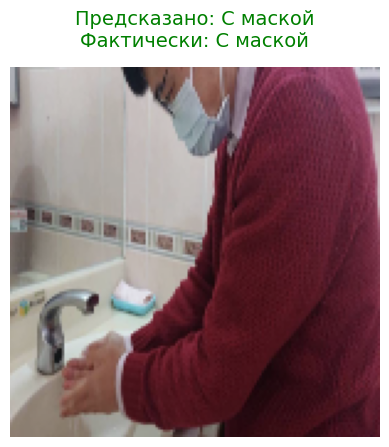

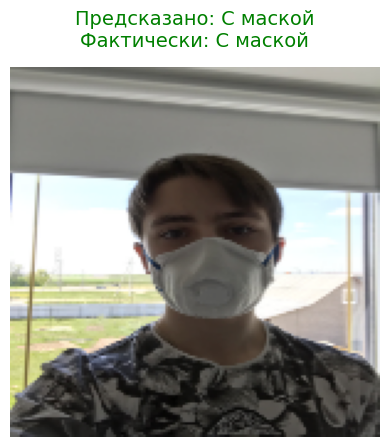

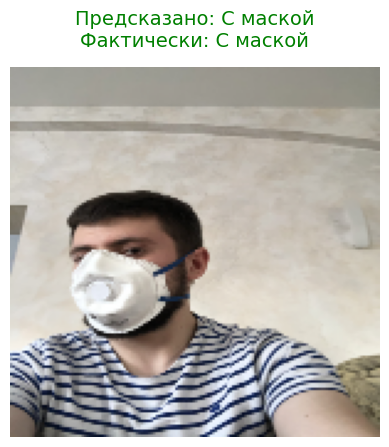

In [39]:
# Визуализируем 5 случайных предсказаний на тестовой выборке
for i in range(5):
    idx = np.random.randint(0, len(X_test))           # Случайный индекс
    img = X_test[idx]                                 # Изображение
    pred = np.argmax(model.predict(img[np.newaxis, ...], verbose=0), axis=1)[0]  # Предсказание
    pred_label = "С маской" if pred == 0 else "Без маски"  # Предсказанная метка
    true_label = "С маской" if y_test[idx] == 0 else "Без маски"  # Истинная метка

    # Определяем цвет заголовка: зелёный — верно, красный — ошибка
    color = 'green' if pred_label == true_label else 'red'

    # Отображаем изображение
    plt.imshow(img)
    plt.title(f"Предсказано: {pred_label}\nФактически: {true_label}",
              color=color, fontsize=14, pad=15)
    plt.axis('off')
    plt.show()